In [ ]:
## Library bb_eval_utils.py

In [ ]:
import matplotlib.path as pltPath
import numpy as np
import math


''' 
    target_idx indicate whether we are working on binary seg or multi seg problem. 
    this idx will be used to retrieve correct mask from ground truth, where:
    0 - background
    1 - skin
    2 - eczema
'''
def compute_coverage_precision(true_mask, boxes, target_idx=2):

    pixel_box_num = np.zeros(shape=true_mask.shape, dtype=np.int8)
    # print('before', boxes)

    boxes_area = 0
    pixels_in_box_and_mask = 0
    pixels_in_mask = 0

    # coordinate transformation
    for box in boxes:
        for point in box:
            point[1] = true_mask.shape[0] - point[1]

    # iterate over all pixels to find if it is contained in box(es)
    for i in range(true_mask.shape[0]):
        for j in range(true_mask.shape[1]):
            # count the number of eczema (or skin) pixels in mask (E_m)
            if true_mask[i, j, target_idx] > 0:
                pixels_in_mask += 1

            for box in boxes:
                path = pltPath.Path([box[0], box[1], box[2], box[3]])
                if path.contains_points([[j,true_mask.shape[0] - i]]):
                    # count pixels in both ground truth mask and boxes (TP)
                    if true_mask[i, j, target_idx] > 0:
                        pixels_in_box_and_mask += 1
                        # debug
                        

                    pixel_box_num[i,j] += 100
                    # accumulate to calculate the union region of boxes (A_b)
                    boxes_area += 1
                    break

    plt.imshow(pixel_box_num)
    cv2.imwrite("/path_to_proj_dir/output/predictions/test/test.jpg", pixel_box_num)

    # area_all_crops = true_mask.shape[0] * true_mask.shape[1]
    # area = true_mask.shape[0] * true_mask.shape[1]

    # define evaluation metrics
    coverage = 0 if pixels_in_mask==0 else pixels_in_box_and_mask / pixels_in_mask
    precision = 0 if boxes_area==0 else pixels_in_box_and_mask / boxes_area

    # print(pixels_in_mask / area)
    print('current coverage=', coverage)
    print('current precision=', precision)

    return coverage, precision

def compute_f1(cov, prec):
    #f1 = 2* c*q / (c+q)
    # print("### Standard error of the f1 score ###")
    se_prec = np.std(prec)/math.sqrt(len(prec)) #se = standard error
    se_cov = np.std(cov)/math.sqrt(len(cov))
    se_prec_cov = se_prec + se_cov

    #re = relative_error
    re_f1 = se_prec/np.mean(prec) + se_cov/np.mean(cov) + se_prec_cov/(np.mean(prec)+np.mean(cov))
    f1 =  2*np.mean(prec)*np.mean(cov)/(np.mean(prec)+np.mean(cov))

    # print("F1 score:", 2*np.mean(prec)*np.mean(cov)/(np.mean(prec)+np.mean(cov)), "+/-", re_f1)
    return f1, re_f1




In [ ]:
# @Author:  zihaowang
# @Email:   zihao.wang20@alumni.imperial.ac.uk
# @Website: www.wangzihao.org
# @Date:    2021-01-19 15:29:02
# @Last Modified by:   zihaowang
# @Last Modified time: 2021-02-08 23:29:41

"""# Dataloader and utility functions """
# helper function for data visualization

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

def visualize(**images):
    """ Plot images in one row """
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def run_sigle_pred(model, input_dir, output_dir, file_name, preprocessing=None, target_idx=2, resize_ratio=0.4, refno=None, visno=None):
    # config path
    mask_dir = os.path.join(output_dir, "masks")
    crop_dir = os.path.join(output_dir, "crops")
    box_dir = os.path.join(output_dir, "boxes")
    
    
    # create folder if not exist
    if not os.path.exists(mask_dir):
        os.system("mkdir -p " + mask_dir)
    if not os.path.exists(crop_dir):
        os.system("mkdir -p " + crop_dir)
    if not os.path.exists(box_dir):
        os.system("mkdir -p " + box_dir)
    print("directory created!")
    
    # clear previous output for same image
    print("checking previous duplicate croppings...")
    cmd = "rm " + crop_dir + "/" + file_name.split(".")[0] + "*.jpg"
    os.system(cmd)
    
    
    # read and resize image
    image = cv2.imread(input_dir)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_height, image_width, channels = image.shape
    target_height = int((image_height / 32) * resize_ratio) * 32
    target_width = int((image_width / 32) * resize_ratio) * 32
    
    image = cv2.resize(image, (target_width, target_height), interpolation = cv2.INTER_AREA)
    image_cp = image.copy()
    
    # preprocessing (lambda transformation) for prediction
    if preprocessing:
        sample = preprocessing(image=image)
        image = sample['image']
        
    image = np.expand_dims(image, axis=0)
    
    # get prediction
    pr_mask = model.predict(image)

    # change the last number to decide which mask to output. [0: background; 1: skin; 2: eczema]
    pr_img = pr_mask[0,:,:,target_idx]
    pr_img = (pr_img * 255).astype(np.uint8)
    
    # output predicted mask
    cv2.imwrite(os.path.join(mask_dir, "pred_" + file_name), pr_img)
    # debug
    # plt.figure()
    # plt.imshow(pr_img)
    # print("mask saved!")
    
    # generate bounding boxes for each predicted mask
    mask = cv2.imread(os.path.join(mask_dir, "pred_" + file_name))
    result = mask.copy()
    gray = cv2.cvtColor(mask,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)[1]
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    num_crops = 0
    crop_fns = []
    
#     image_cp = cv2.bitwise_and(image_cp, image_cp, mask = thresh)
    # debug crops
#     plt.figure()
#     plt.imshow(image_cp)
    
    # iterate through boxes
    for cntr in contours:
        rect = cv2.minAreaRect(cntr)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        area = cv2.contourArea(cntr)
        
        # drop boxes with small area
        if(area > 2500.0):
            img_crop = crop_rect(image_cp, rect, box)
            crop_file_name = refno + "_vis-" + visno + "_" + file_name.split(".")[0] + "_crop-" + str(num_crops) + ".jpg"
            plt.imsave(os.path.join(crop_dir, crop_file_name), img_crop)
            crop_fns.append(crop_file_name)
            result = cv2.drawContours(result,[box],0,(0,0,255),2)
            num_crops += 1
            
            
    # save bounding boxes
    box_file_name = refno + "_vis-" + visno + "_" + file_name.split(".")[0] + "_UNet.jpg"
    cv2.imwrite(os.path.join(box_dir, box_file_name), result) 
    
    print(file_name, ": cropping done!")
    
    return num_crops, crop_fns


def crop_rect(image, rect, box):    
    width = int(rect[1][0])
    height = int(rect[1][1])
    
    src_pts = box.astype("float32")
    # coordinate of the points in box points after the rectangle has been
    # straightened
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")

    # the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)

    # directly warp the rotated rectangle to get the straightened rectangle
    warped = cv2.warpPerspective(image, M, (width, height))
    
    return warped

# classes for data loading and preprocessing
class Dataset:
    """ Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['background', 'skin', 'eczema']
    # CLASSES = ['background', 'skin']
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            is_train=True,
            use_full_resolution=False,
            binary_seg=False,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        # self.class_values = [0, 127, 255]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.use_full_resolution = use_full_resolution
        self.is_train = is_train
        self.binary_seg = binary_seg

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        # convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # define whether or not to resize the input stream to save program running memory
        # note: the size of input has to be divisible by 32 for tensorflow to process
        if not self.use_full_resolution:
            target_ratio = 0.2
        else:
            target_ratio = 1

        image_height, image_width, channels = image.shape
        target_height = 768 if self.is_train else int((image_height / 32) * target_ratio) * 32
        target_width = 1024 if self.is_train else int((image_width / 32) * target_ratio) * 32
        image = cv2.resize(image, (target_width, target_height), interpolation = cv2.INTER_AREA)

        # load the mask in gray scale, RGB -> single value
        mask = cv2.imread(self.masks_fps[i], 0)
        # 21 Jan, 2021: resize the mask to save memory
        mask = cv2.resize(mask, (target_width, target_height), interpolation = cv2.INTER_AREA)
        # reorganize the RGB value in masks

        if self.binary_seg:
            # binary segmentation
            mask[mask > 1] = 1
        else:
            # multi-class classfication
            mask[mask == 127] = 1
            mask[mask == 255] = 2
            mask[mask > 2] = 1

        # print(np.unique(mask))
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        # debug msg
        # print(mask.shape)

        # # apply augmentations
        # if self.augmentation:
        #     sample = self.augmentation(image=image, mask=mask)
        #     image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches

    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """

    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return batch

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)


def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
sm.set_framework('keras')
import csv
import math



################################ Model loading (this part will be replaced with new data type soon) ################################
BIN_SEG = True

MODEL_NAME = '/mul_seg_model.h5'
CLASSES = ['background', 'skin', 'eczema']
WEIGHTS = np.array([1, 1, 1])
target_idx = 2

if BIN_SEG:
    MODEL_NAME = '/bin_seg_model.h5'
    CLASSES = ['background', 'skin']
    WEIGHTS = np.array([1, 1])
    target_idx = 1

BACKBONE = 'efficientnetb3'
LR = 0.0001
preprocess_input = sm.get_preprocessing(BACKBONE)

"""# Model Evaluation"""
# config PROJ_DIR according to your environment
PROJ_DIR = "/path_to_proj_dir"
PRED_DIR = os.path.join(PROJ_DIR, 'output/predictions/test')
BB_DIR = os.path.join(PROJ_DIR, 'output/bounding_boxes/test')
EVAL_DIR = os.path.join(PROJ_DIR, 'output/evaluations')
MODEL_DIR = os.path.join(PROJ_DIR, 'output')
DATA_DIR = os.path.join(PROJ_DIR, 'data')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=None,
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False,
    use_full_resolution=False,
    binary_seg=BIN_SEG,
)
eczema_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=['background', 'skin', 'eczema'], 
    augmentation=None,
    preprocessing=get_preprocessing(preprocess_input),
    is_train=False,
    use_full_resolution=False,
    binary_seg=0,
)
test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

# define network parameters
n_classes = len(CLASSES)
# select training mode
activation = 'sigmoid' if n_classes == 1 else 'softmax'
#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
# define optomizer
optim = keras.optimizers.Adam(LR)
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# Set class weights for diss_loss (background: 1, skin: 1, eczema: 1)
dice_loss = sm.losses.DiceLoss(class_weights=WEIGHTS)
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

# load trained segmentation model
model.load_weights(MODEL_DIR + MODEL_NAME)

Clearing previous masks...
Done! Now saving new prediction masks...
current coverage= 0.7911027666953506
current precision= 0.2544173759906076
current coverage= 0.9948234933762157
current precision= 0.4333875982439519
Done!


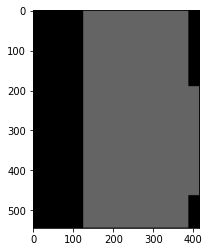

In [ ]:

################################ Mask prediction and evaluation ################################
"""# Saving Masks Predictions"""
# save all predictions 
# clear previous predictions
print('Clearing previous masks...')
os.system("rm " + PRED_DIR + "/*.jpg")
os.system("rm " + PRED_DIR + "/*.JPG")
os.system("rm " + BB_DIR + "/*.jpg")
os.system("rm " + BB_DIR + "/*.JPG")
os.system("rm " + EVAL_DIR + "/test.csv")
print('Done! Now saving new prediction masks...')

# Feb 8: export evaluation result as csv file 
cov = []
prec = []
with open(EVAL_DIR + '/test.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["file_name", "coverage", "precision", "f1_score", "standard_error"])
#     for i in range(len(test_dataset)):
    for i in range(2):
        # save predicted masks
        image, _ = test_dataset[i]
        _, gt_mask = eczema_dataset[i]
        image = np.expand_dims(image, axis=0)
        pr_mask = model.predict(image)
        # change the last number to decide which mask to output. [0: background; 1: skin; 2: eczema]
        pr_img = pr_mask[0,:,:,target_idx]
        pr_img = (pr_img * 255).astype(np.uint8)
        cv2.imwrite(os.path.join(PRED_DIR, "pred_" + test_dataset.ids[i]), pr_img)
        # generate bounding boxes for each predicted mask
        boxes = []
        img = cv2.imread(os.path.join(PRED_DIR, "pred_" + test_dataset.ids[i]))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)[1]
        result = img.copy()
        contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]
        for cntr in contours:
            rect = cv2.minAreaRect(cntr)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            area = cv2.contourArea(cntr)
            # Abandon boxes with too small area
            if(area > 2500):
                boxes.append(box)
                result = cv2.drawContours(result,[box],0,(0,0,255),2)


        # Feb 8: compute performance of bounding boxes
        coverage_per_image, precision_per_image = compute_coverage_precision(gt_mask, boxes, target_idx=2)
        cov.append(coverage_per_image)
        prec.append(precision_per_image)
        writer.writerow([test_dataset.ids[i], coverage_per_image, precision_per_image])
        # save bounding boxes
        cv2.imwrite(os.path.join(BB_DIR, "bb_" + test_dataset.ids[i]), result)    
    # Feb 8: append the mean performance to the end of csv
    f1, se = compute_f1(cov, prec)
    writer.writerow(['overall', np.mean(cov), np.mean(prec), f1, se])
    print('Done!')


In [ ]:
!python ../src/eval_of_ad_identification.py --seg_type ad --suffix test --model_dir /ad_base_ce_bestOnly/base_ad_ce.h5